In [9]:
# 0) Parâmetros globais (edite aqui)
import os

# Caminhos
DATA_PATH = os.getenv('DATA_PATH', '/content/drive/MyDrive/FineTunning/TechChallenge03/trn.json.gz')
ART_DIR = os.getenv('ART_DIR', '/content/drive/MyDrive/FineTunning/TechChallenge03/artifacts')
OUTPUT_DIR = os.getenv('OSS_OUTPUT_DIR', '/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned')
MERGED_OUTPUT_DIR = os.getenv('OSS_MERGED_DIR', '/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_final')
TRAIN_SAVE_JSONL = os.getenv('TRAIN_SAVE_JSONL', os.path.join(ART_DIR, 'train_dataset_used.jsonl'))
TRAIN_SAVE_GZ = os.getenv('TRAIN_SAVE_GZ', os.path.join(ART_DIR, 'train_dataset_used.jsonl.gz'))

# Semente
SEED = int(os.getenv('SEED', 42))

# Leitura/Limpeza
MAX_RECORDS = int(os.getenv('MAX_RECORDS_FOR_FT', 200_000))
TITLE_MIN_LEN = int(os.getenv('TITLE_MIN_LEN', 2))
CONTENT_MIN_LEN = int(os.getenv('CONTENT_MIN_LEN', 5))

# Dataset/Splits
TEST_SIZE = float(os.getenv('TEST_SIZE', 0.2))
VAL_SIZE = float(os.getenv('VAL_SIZE', 0.5))

# Modelo e geração
BASE_OSS_MODEL = os.getenv('BASE_OSS_MODEL', 'TinyLlama/TinyLlama-1.1B-Chat-v1.0')
OSS_MAX_SEQ_LEN = int(os.getenv('OSS_MAX_SEQ_LEN', 1024))
MAX_SEQ_LEN = OSS_MAX_SEQ_LEN  # alias para compatibilidade
OSS_SUBSET = int(os.getenv('OSS_SUBSET', 4000))
OSS_EVAL_N = int(os.getenv('OSS_EVAL_N', 200))
OSS_TEST_N = int(os.getenv('OSS_TEST_N', 200))
GEN_MAX_NEW_TOKENS = int(os.getenv('GEN_MAX_NEW_TOKENS', 96))
GEN_BATCH_SIZE = int(os.getenv('GEN_BATCH_SIZE', 8))
GEN_DO_SAMPLE = bool(int(os.getenv('GEN_DO_SAMPLE', 1)))

# Treino
OSS_LR = float(os.getenv('OSS_LR', 2e-4))
OSS_BATCH_SIZE = int(os.getenv('OSS_BATCH_SIZE', 4))
OSS_GRAD_ACCUM = int(os.getenv('OSS_GRAD_ACCUM', 2))
OSS_EPOCHS = int(os.getenv('OSS_EPOCHS', 2))
OSS_WARMUP_STEPS = int(os.getenv('OSS_WARMUP_STEPS', 50))

# LoRA
LORA_R = int(os.getenv('LORA_R', 16))
LORA_ALPHA = int(os.getenv('LORA_ALPHA', 16))
LORA_DROPOUT = float(os.getenv('LORA_DROPOUT', 0.05))

print('Parâmetros carregados:')
print({k:v for k,v in globals().items() if k.isupper()})

Parâmetros carregados:
{'DATA_PATH': '/content/drive/MyDrive/FineTunning/TechChallenge03/trn.json.gz', 'ART_DIR': '/content/drive/MyDrive/FineTunning/TechChallenge03/artifacts', 'OUTPUT_DIR': '/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned', 'MERGED_OUTPUT_DIR': '/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_final', 'TRAIN_SAVE_JSONL': '/content/drive/MyDrive/FineTunning/TechChallenge03/artifacts/train_dataset_used.jsonl', 'TRAIN_SAVE_GZ': '/content/drive/MyDrive/FineTunning/TechChallenge03/artifacts/train_dataset_used.jsonl.gz', 'SEED': 42, 'MAX_RECORDS': 200000, 'TITLE_MIN_LEN': 2, 'CONTENT_MIN_LEN': 5, 'TEST_SIZE': 0.2, 'VAL_SIZE': 0.5, 'BASE_OSS_MODEL': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0', 'OSS_MAX_SEQ_LEN': 1024, 'MAX_SEQ_LEN': 1024, 'OSS_SUBSET': 4000, 'OSS_EVAL_N': 200, 'OSS_TEST_N': 200, 'GEN_MAX_NEW_TOKENS': 96, 'GEN_BATCH_SIZE': 8, 'GEN_DO_SAMPLE': True, 'OSS_LR': 0.0002, 'OSS_BATCH_SIZE': 4, 'OSS_GRAD_ACCUM': 2, 'OSS_EPOC

# Tech Challenge (Colab GPU): Fine-tuning OSS com Unsloth + TinyLlama

Pipeline completo para rodar no Google Colab com GPU (sem custo de API):

1) Montar Google Drive e instalar dependências
2) Carregar e limpar dados (title → content) a partir de `/content/drive/MyDrive/FineTunning/TechChallenge03/trn.json.gz`
3) Preparar dataset para SFT (prompts + splits)
4) Avaliação baseline (modelo base, sem FT)
5) Treinamento LoRA com Unsloth + TinyLlama
6) Avaliação pós-FT e gráficos
7) Salvar artefatos (adapter, métricas, amostras) no Drive

Observações:
- Use GPU (Runtime > Change runtime type > T4/L4/A100).
- bitsandbytes (4-bit) ajuda caber na VRAM.
- Ajuste OSS_SUBSET/OSS_EVAL_N/OSS_EPOCHS conforme tempo e GPU.

In [10]:
# 1) Montar Drive e instalar dependências (Colab)
import sys, subprocess, os

IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    pass

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

PKGS = [
    'unsloth>=2024.8.12',
    'transformers>=4.43',
    'accelerate>=0.33',
    'datasets>=2.20',
    'peft>=0.12.0',
    'trl>=0.9.6',
    'sacrebleu',
    'rouge-score',
    'matplotlib',
    'tiktoken',
    'bert-score>=0.3.13',
    'nltk>=3.8'
]

print('Instalando dependências...')
subprocess.check_call([sys.executable, '-m', 'pip', 'install', *PKGS])

# Garantir bitsandbytes atualizado para 4-bit
try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-U', 'bitsandbytes>=0.43.1'])
    import importlib, bitsandbytes as bnb  # type: ignore
    importlib.reload(bnb)
    print('bitsandbytes version:', getattr(bnb, '__version__', 'unknown'))
except Exception as e:
    print('Aviso: não foi possível atualizar bitsandbytes automaticamente:', e)

print('Setup concluído.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Instalando dependências...
bitsandbytes version: 0.47.0
Setup concluído.


In [11]:
# 2) Carregar e limpar dados (title → content)
import gzip, json, re
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

assert os.path.exists(DATA_PATH), f'Arquivo não encontrado: {DATA_PATH}'

rows, count = [], 0
with gzip.open(DATA_PATH, 'rt', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            continue
        rows.append({'title': obj.get('title'), 'content': obj.get('content')})
        count += 1
        if count >= MAX_RECORDS:
            break

df_raw = pd.DataFrame(rows, columns=['title','content']).dropna(how='all')
print('Lidas linhas:', len(df_raw))

EMPTY_STRINGS = {'none','nan','null','na','n/a'}
def clean_text(s):
    if s is None:
        return None
    if isinstance(s, float) and np.isnan(s):
        return None
    if isinstance(s, str) and s.strip().lower() in EMPTY_STRINGS:
        return None
    s = str(s)
    s = re.sub(r'<[^>]+>', ' ', s)
    s = re.sub(r'[`*_#>\"]', ' ', s)
    s = s.replace('\r', ' ').replace('\n', ' ')
    s = re.sub(r'\s+', ' ', s).strip(" '\"")
    if not s or s.strip().lower() in EMPTY_STRINGS:
        return None
    return s

df = df_raw.copy()
df['title'] = df['title'].apply(clean_text)
df['content'] = df['content'].apply(clean_text)

before = len(df)
df = df.dropna(subset=['title','content']).drop_duplicates(subset=['title','content'])
# Filtros mínimos parametrizados
before_len = len(df)
df = df[df['title'].str.len() >= TITLE_MIN_LEN]
df = df[df['content'].str.len() >= CONTENT_MIN_LEN]
print(f'Após limpeza: {len(df)} (removidos {before-len(df)}; por tamanho {before_len-len(df)})')

Lidas linhas: 200000
Após limpeza: 141505 (removidos 58495; por tamanho 32)


In [12]:
# 3) Prepare dataset for SFT (prompts + splits)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

SYSTEM_PROMPT = os.getenv('OSS_SYSTEM_PROMPT', 'You are an assistant that writes detailed product descriptions from a given title.')
PROMPT_COL = 'prompt'
TARGET_COL = 'target'

df_prep = df[['title','content']].copy()
df_prep[PROMPT_COL] = df_prep['title'].apply(lambda t: f"[SYSTEM]\n{SYSTEM_PROMPT}\n[USER]\nTitle: {t}\n[ASSISTANT]\n")
df_prep[TARGET_COL] = df_prep['content']

test_size = float(os.getenv('TEST_SIZE', 0.2))
val_size = float(os.getenv('VAL_SIZE', 0.5))

train_df, temp_df = train_test_split(df_prep[[PROMPT_COL,TARGET_COL]], test_size=test_size, random_state=SEED, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=val_size, random_state=SEED, shuffle=True)

print(f"Splits → train={len(train_df):,}, val={len(val_df):,}, test={len(test_df):,}")

datasets_dict = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True)),
    'test': Dataset.from_pandas(test_df.reset_index(drop=True)),
})

datasets_dict

Splits → train=113,204, val=14,150, test=14,151


DatasetDict({
    train: Dataset({
        features: ['prompt', 'target'],
        num_rows: 113204
    })
    validation: Dataset({
        features: ['prompt', 'target'],
        num_rows: 14150
    })
    test: Dataset({
        features: ['prompt', 'target'],
        num_rows: 14151
    })
})

In [13]:
# 4) Load base model (Unsloth + TinyLlama) and baseline evaluation (val & test) — batched generation
import torch
from unsloth import FastLanguageModel
from transformers import AutoTokenizer
from rouge_score import rouge_scorer
import sacrebleu
import numpy as np
from math import ceil

MAX_SEQ_LEN = OSS_MAX_SEQ_LEN

device = 'cuda' if torch.cuda.is_available() else ('mps' if getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available() else 'cpu')
print('Device:', device)

print('Loading base model...')
load_in_4bit = True if device == 'cuda' else False
try:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = BASE_OSS_MODEL,
        max_seq_length = MAX_SEQ_LEN,
        dtype = None,
        load_in_4bit = load_in_4bit,
    )
except Exception as e:
    print('4-bit load failed. Falling back to non-4bit. Reason:', e)
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = BASE_OSS_MODEL,
        max_seq_length = MAX_SEQ_LEN,
        dtype = None,
        load_in_4bit = False,
    )

# Subsets to speed up
if datasets_dict['train'].num_rows > OSS_SUBSET:
    datasets_dict['train'] = datasets_dict['train'].shuffle(seed=SEED).select(range(OSS_SUBSET))
subset_val = datasets_dict['validation'].select(range(min(OSS_EVAL_N, datasets_dict['validation'].num_rows)))
subset_test = datasets_dict['test'].select(range(min(OSS_TEST_N, datasets_dict['test'].num_rows)))

model.eval()
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
    model.resize_token_embeddings(len(tokenizer))

# Batched generation and precise prompt removal via input length
@torch.no_grad()
def generate_batch(prompts, max_new_tokens=GEN_MAX_NEW_TOKENS, do_sample=False, temperature=0.0, top_p=0.9):
    inputs = tokenizer(prompts, return_tensors='pt', padding=True, truncation=True, max_length=MAX_SEQ_LEN).to(model.device)
    input_lengths = (inputs['input_ids'] != tokenizer.pad_token_id).sum(dim=1)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    # Remove prompt tokens
    result = []
    for i, txt in enumerate(texts):
        prompt_text = tokenizer.decode(outputs[i][:input_lengths[i]], skip_special_tokens=True)
        result.append(txt[len(prompt_text):].strip())
    return result

# Deterministic evaluation

def eval_dataset(ds, batch_size=GEN_BATCH_SIZE):
    refs, hyps = [], []
    n = ds.num_rows
    for i in range(0, n, batch_size):
        batch = ds.select(range(i, min(i+batch_size, n)))
        prompts = [ex['prompt'] for ex in batch]
        hyps.extend(generate_batch(prompts, do_sample=False, temperature=0.0))
        refs.extend([ex['target'].strip() for ex in batch])
    bleu = sacrebleu.corpus_bleu(hyps, [refs]).score
    scorer = rouge_scorer.RougeScorer(['rougeLsum'], use_stemmer=True)
    rougeL = float(np.mean([scorer.score(r, h)['rougeLsum'].fmeasure for r, h in zip(refs, hyps)]))
    return bleu, rougeL, refs, hyps

# Baseline (val & test)
bleu_base_val, rougeL_base_val, refs_val, hyps_base_val = eval_dataset(subset_val)
print(f'Baseline (val) → BLEU={bleu_base_val:.2f} | ROUGE-L={rougeL_base_val:.3f}')
bleu_base_test, rougeL_base_test, refs_test_base, hyps_base_test = eval_dataset(subset_test)
print(f'Baseline (test) → BLEU={bleu_base_test:.2f} | ROUGE-L={rougeL_base_test:.3f}')

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Device: cuda
Loading base model...
==((====))==  Unsloth 2025.9.7: Fast Llama patching. Transformers: 4.55.4.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/762M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Baseline (val) → BLEU=0.21 | ROUGE-L=0.083
Baseline (test) → BLEU=0.15 | ROUGE-L=0.074


In [14]:
# 5) Treinamento LoRA (Unsloth + TRL SFTTrainer)
from transformers import TrainingArguments, __version__ as HF_VER
from trl import SFTTrainer
import inspect

LORA_R = int(os.getenv('LORA_R', 16))
LORA_ALPHA = int(os.getenv('LORA_ALPHA', 16))
LORA_DROPOUT = float(os.getenv('LORA_DROPOUT', 0.05))
LR = float(os.getenv('OSS_LR', 2e-4))
BATCH_SIZE = int(os.getenv('OSS_BATCH_SIZE', 4))
GR_ACCUM = int(os.getenv('OSS_GRAD_ACCUM', 2))
EPOCHS = int(os.getenv('OSS_EPOCHS', 2))
WARMUP = int(os.getenv('OSS_WARMUP_STEPS', 50))
OUTPUT_DIR = os.getenv('OSS_OUTPUT_DIR', '/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned')

# Aplicar LoRA (com Unsloth)
model = FastLanguageModel.get_peft_model(
    model,
    r=LORA_R,
    target_modules=['q_proj','k_proj','v_proj','o_proj','gate_proj','up_proj','down_proj'],
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias='none',
    use_gradient_checkpointing=True,
)

# Preparar dataset com campo 'text' (prompt+target) e tokenizar com máscara na perda

def format_row_keep(ex):
    return {'text': ex['prompt'] + ex['target']}

train_ds = datasets_dict['train'].map(format_row_keep, remove_columns=[])
val_ds = datasets_dict['validation'].map(format_row_keep, remove_columns=[])

# Tokenização batelada com padding fixo e máscara: só aprende depois de "[ASSISTANT]\n"

def tokenize_and_mask(batch):
    texts = batch['text']
    enc = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=MAX_SEQ_LEN,
        return_attention_mask=True,
    )
    labels = []
    for text, input_ids, attn in zip(texts, enc['input_ids'], enc['attention_mask']):
        idx = text.find('[ASSISTANT]\n')
        if idx == -1:
            p_len = 0
        else:
            prefix = text[:idx]
            prefix_ids = tokenizer(prefix, add_special_tokens=False, truncation=True, max_length=MAX_SEQ_LEN)['input_ids']
            p_len = min(len(prefix_ids), len(input_ids))
        lab = input_ids.copy()
        # mascarar pads
        for j, a in enumerate(attn):
            if a == 0:
                lab[j] = -100
        # mascarar prompt
        for j in range(p_len):
            lab[j] = -100
        labels.append(lab)
    enc['labels'] = labels
    return enc

train_tok = train_ds.map(tokenize_and_mask, batched=True, remove_columns=train_ds.column_names)
val_tok = val_ds.map(tokenize_and_mask, batched=True, remove_columns=val_ds.column_names)

# Compatibilidade Transformers v4/v5 via inspeção da assinatura
args_kwargs = dict(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GR_ACCUM,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    warmup_steps=WARMUP,
    bf16=(torch.cuda.is_available() and torch.cuda.is_bf16_supported()),
    fp16=(torch.cuda.is_available() and not torch.cuda.is_bf16_supported()),
    logging_steps=10,
    eval_steps=100,
    save_steps=200,
    save_total_limit=1,
    report_to=[],
)

sig_params = set(inspect.signature(TrainingArguments.__init__).parameters.keys())
if 'eval_strategy' in sig_params:
    args_kwargs['eval_strategy'] = 'steps'
elif 'evaluation_strategy' in sig_params:
    args_kwargs['evaluation_strategy'] = 'steps'
else:
    print('Aviso: parâmetro de avaliação por estratégia não encontrado; usaremos eval_steps para controlar a frequência.')

if 'save_strategy' in sig_params:
    args_kwargs['save_strategy'] = 'steps'

args = TrainingArguments(**args_kwargs)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    args=args,
    packing=False,
    dataset_text_field=None,
)

print('Treinando...')
trainer.train()
print('Treino concluído.')

# Salvar adapter
import os, sys, traceback
os.makedirs(OUTPUT_DIR, exist_ok=True)
trainer.save_model(OUTPUT_DIR)
print('Adapter salvo em:', OUTPUT_DIR)

# Modo recomendado: recarregar base em FP16 (sem 4-bit) e mesclar adapter → salva modelo completo
merged_saved = False
try:
    from peft import PeftModel
    from transformers import AutoModelForCausalLM, AutoTokenizer
    print('Mesclando recarregando base em FP16 (sem 4-bit) e aplicando adapter...')
    base_fp16 = AutoModelForCausalLM.from_pretrained(
        BASE_OSS_MODEL,
        torch_dtype=torch.float16,
        device_map='auto',
    )
    merged_model = PeftModel.from_pretrained(base_fp16, OUTPUT_DIR)
    merged_model = merged_model.merge_and_unload()
    os.makedirs(MERGED_OUTPUT_DIR, exist_ok=True)
    merged_model.save_pretrained(MERGED_OUTPUT_DIR, safe_serialization=True)
    try:
        tokenizer.save_pretrained(MERGED_OUTPUT_DIR)
    except Exception:
        AutoTokenizer.from_pretrained(BASE_OSS_MODEL).save_pretrained(MERGED_OUTPUT_DIR)
    print('Modelo mesclado salvo em:', MERGED_OUTPUT_DIR)
    merged_saved = True
except Exception as e:
    print('Falha no merge via recarga FP16:', e)
    traceback.print_exc()

# Fallback: tentar merge direto no modelo atual (sem mover para CPU)
if not merged_saved:
    try:
        if hasattr(model, 'merge_and_unload'):
            print('Tentando merge no modelo atual (PEFT)...')
            merged2 = model.merge_and_unload()
            os.makedirs(MERGED_OUTPUT_DIR, exist_ok=True)
            merged2.save_pretrained(MERGED_OUTPUT_DIR, safe_serialization=True)
            tokenizer.save_pretrained(MERGED_OUTPUT_DIR)
            print('Modelo mesclado salvo (fallback PEFT direto) em:', MERGED_OUTPUT_DIR)
            merged_saved = True
    except Exception as e2:
        print('Falha PEFT merge direto:', e2)
        traceback.print_exc()

# Fallback final: salvar em diretório local do projeto
if not merged_saved:
    try:
        local_dir = os.path.abspath('./tinyllama_amazon_final')
        print('Salvando fallback local em:', local_dir)
        os.makedirs(local_dir, exist_ok=True)
        if 'merged_model' in locals():
            to_save = merged_model
        elif 'merged2' in locals():
            to_save = merged2
        else:
            to_save = model
        to_save.save_pretrained(local_dir, safe_serialization=True)
        tokenizer.save_pretrained(local_dir)
        print('Modelo salvo (fallback local) em:', local_dir)
        merged_saved = True
    except Exception as e3:
        print('Falha ao salvar fallback local:', e3)
        traceback.print_exc()

if not merged_saved:
    print('Aviso: não foi possível mesclar e salvar o modelo completo. Use o adapter em OUTPUT_DIR.')

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.9.7 patched 22 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14150 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14150 [00:00<?, ? examples/s]

Treinando...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,000 | Num Epochs = 2 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 12,615,680 of 1,112,664,064 (1.13% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
100,2.185500,2.212520
200,2.186400,2.192652
300,2.102800,2.184402
400,2.144300,2.176960
500,2.179900,2.171815
600,2.114900,2.172626
700,2.036000,2.171207
800,2.062400,2.169422
900,2.104300,2.167396
1000,2.102300,2.166390


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Treino concluído.
Adapter salvo em: /content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned
Mesclando recarregando base em FP16 (sem 4-bit) e aplicando adapter...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Modelo mesclado salvo em: /content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_final


In [15]:
# 5.1) Save the training dataset used (title/content) as NDJSON (+GZ)
import re, json, gzip, os
os.makedirs(ART_DIR, exist_ok=True)

def extract_title(prompt: str) -> str:
    # Extract after 'Title:' until '[ASSISTANT]' (fallback supports 'Título:' for older runs)
    try:
        start = prompt.index('Title:') + len('Title:')
        end = prompt.index('[ASSISTANT]', start)
        return prompt[start:end].strip()
    except ValueError:
        m = re.search(r'(?:Title|Título):\s*(.*?)\s*\[ASSISTANT\]', prompt, flags=re.S)
        return m.group(1).strip() if m else ''

train_examples = []
for ex in datasets_dict['train']:
    t = extract_title(ex['prompt'])
    c = ex['target'] if isinstance(ex['target'], str) else str(ex['target'])
    if t and c:
        train_examples.append({'title': t, 'content': c})

# Save JSONL and JSONL.GZ
with open(TRAIN_SAVE_JSONL, 'w', encoding='utf-8') as f:
    for obj in train_examples:
        f.write(json.dumps(obj, ensure_ascii=False) + '\n')
with gzip.open(TRAIN_SAVE_GZ, 'wt', encoding='utf-8') as f:
    for obj in train_examples:
        f.write(json.dumps(obj, ensure_ascii=False) + '\n')
print(f'Training dataset saved to:\n- {TRAIN_SAVE_JSONL}\n- {TRAIN_SAVE_GZ}\nTotal examples: {len(train_examples)}')

Training dataset saved to:
- /content/drive/MyDrive/FineTunning/TechChallenge03/artifacts/train_dataset_used.jsonl
- /content/drive/MyDrive/FineTunning/TechChallenge03/artifacts/train_dataset_used.jsonl.gz
Total examples: 4000



Resumo comparativo (TEST):
Baseline → BLEU=0.15 | ROUGE-L=0.074
Fine-tuned → BLEU=0.30 | ROUGE-L=0.082


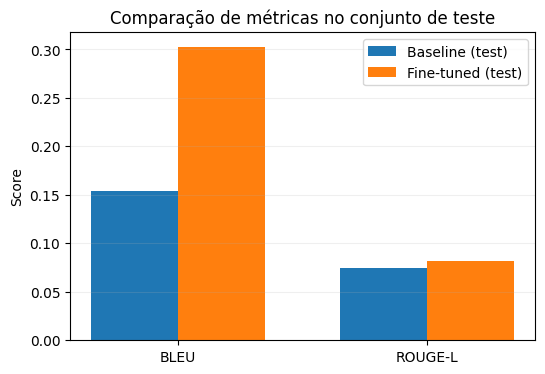

Artefatos salvos em: /content/drive/MyDrive/FineTunning/TechChallenge03/artifacts


In [16]:
# 6) Avaliação pós-FT e gráficos + salvamento de métricas (comparando com baseline de teste) — batelada
import matplotlib.pyplot as plt

# Reutiliza subset_test e generate_batch/GEN_BATCH_SIZE definidos no passo 4
model.eval()

def eval_dataset_after_ft(ds, batch_size=GEN_BATCH_SIZE):
    refs, hyps = [], []
    n = ds.num_rows
    for i in range(0, n, batch_size):
        batch = ds.select(range(i, min(i+batch_size, n)))
        prompts = [ex['prompt'] for ex in batch]
        hyps.extend(generate_batch(prompts))
        refs.extend([ex['target'].strip() for ex in batch])
    bleu = sacrebleu.corpus_bleu(hyps, [refs]).score
    scorer = rouge_scorer.RougeScorer(['rougeLsum'], use_stemmer=True)
    rougeL = float(np.mean([scorer.score(r, h)['rougeLsum'].fmeasure for r, h in zip(refs, hyps)]))
    return bleu, rougeL, refs, hyps

bleu_ft, rougeL_ft, refs_test, hyps_ft = eval_dataset_after_ft(subset_test)

print('\nResumo comparativo (TEST):')
print(f"Baseline → BLEU={bleu_base_test:.2f} | ROUGE-L={rougeL_base_test:.3f}")
print(f"Fine-tuned → BLEU={bleu_ft:.2f} | ROUGE-L={rougeL_ft:.3f}")

labels = ['BLEU','ROUGE-L']
baseline_vals = [bleu_base_test, rougeL_base_test]
ft_vals = [bleu_ft, rougeL_ft]

plt.figure(figsize=(6,4))
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, baseline_vals, width, label='Baseline (test)')
plt.bar(x + width/2, ft_vals, width, label='Fine-tuned (test)')
plt.xticks(x, labels)
plt.ylabel('Score')
plt.title('Comparação de métricas no conjunto de teste')
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.show()

# Salvar métricas e amostras no Drive
os.makedirs(ART_DIR, exist_ok=True)

import json
with open(os.path.join(ART_DIR, 'oss_metrics.json'), 'w', encoding='utf-8') as f:
    json.dump({
        'bleu_base_val': float(bleu_base_val),
        'rougeL_base_val': float(rougeL_base_val),
        'bleu_base_test': float(bleu_base_test),
        'rougeL_base_test': float(rougeL_base_test),
        'bleu_ft_test': float(bleu_ft),
        'rougeL_ft_test': float(rougeL_ft)
    }, f, ensure_ascii=False, indent=2)

samples_path = os.path.join(ART_DIR, 'qualitative_samples_test.jsonl')
with open(samples_path, 'w', encoding='utf-8') as f:
    for ex, r_base, r_ft in zip(subset_test, hyps_base_test, hyps_ft):
        f.write(json.dumps({'prompt': ex['prompt'], 'hyp_base': r_base, 'hyp_ft': r_ft, 'ref': ex['target']}, ensure_ascii=False) + '\n')

print('Artefatos salvos em:', ART_DIR)

In [17]:
# 7) Extra quality tests (metrics + paired analysis)
from statistics import mean
from bert_score import score as bert_score
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.translate.meteor_score import meteor_score
import os, json

# Use refs_test (gold), hyps_base_test (baseline) and hyps_ft (fine-tuned) produced in steps 4 and 6.
# Ensure steps 4 and 6 have been run in this session.

def rouge_1_2(hypotheses, references):
    from rouge_score import rouge_scorer
    r1 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    r2 = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=True)
    r1_f = [r1.score(ref, hyp)['rouge1'].fmeasure for ref, hyp in zip(references, hypotheses)]
    r2_f = [r2.score(ref, hyp)['rouge2'].fmeasure for ref, hyp in zip(references, hypotheses)]
    return mean(r1_f), mean(r2_f)

def meteor(hypotheses, references):
    # Some NLTK versions require tokenized input
    scores = []
    for ref, hyp in zip(references, hypotheses):
        try:
            s = meteor_score([ref], hyp)  # some versions accept strings
        except TypeError:
            s = meteor_score([ref.split()], hyp.split())  # fallback: tokens
        scores.append(s)
    return mean(scores)

def distinct_n(corpus, n=2):
    # lexical diversity: proportion of unique n-grams
    ngrams = []
    total = 0
    for sent in corpus:
        tokens = sent.split()
        seq = list(zip(*[tokens[i:] for i in range(n)]))
        ngrams.extend(seq)
        total += max(0, len(tokens) - n + 1)
    unique = len(set(ngrams)) if ngrams else 0
    return (unique / total) if total > 0 else 0.0

def length_ratio(hypotheses, references):
    # avg hyp/ref length ratio (tokens)
    import numpy as np
    ratios = []
    for ref, hyp in zip(references, hypotheses):
        rlen = max(1, len(ref.split()))
        hlen = len(hyp.split())
        ratios.append(hlen / rlen)
    return float(np.mean(ratios))

def bootstrap_winrate(refs, base_hyps, ft_hyps, rounds=300, sample_size=50):
    import random
    from rouge_score import rouge_scorer
    rng = random.Random(123)
    scorer = rouge_scorer.RougeScorer(['rougeLsum'], use_stemmer=True)
    wins = 0
    for _ in range(rounds):
        idx = [rng.randrange(0, len(refs)) for __ in range(min(sample_size, len(refs)))]
        base_scores = [scorer.score(refs[i], base_hyps[i])['rougeLsum'].fmeasure for i in idx]
        ft_scores = [scorer.score(refs[i], ft_hyps[i])['rougeLsum'].fmeasure for i in idx]
        if mean(ft_scores) > mean(base_scores):
            wins += 1
    return wins / rounds if rounds > 0 else 0.0

print('Computing extra metrics...')
r1_base, r2_base = rouge_1_2(hyps_base_test, refs_test)
r1_ft, r2_ft = rouge_1_2(hyps_ft, refs_test)
meteor_base = meteor(hyps_base_test, refs_test)
meteor_ft = meteor(hyps_ft, refs_test)

# English BERTScore
P, R, F1_base = bert_score(hyps_base_test, refs_test, lang='en', verbose=False)
P, R, F1_ft = bert_score(hyps_ft, refs_test, lang='en', verbose=False)
bert_f1_base = float(F1_base.mean())
bert_f1_ft = float(F1_ft.mean())

distinct2_base = distinct_n(hyps_base_test, n=2)
distinct2_ft = distinct_n(hyps_ft, n=2)
len_ratio_base = length_ratio(hyps_base_test, refs_test)
len_ratio_ft = length_ratio(hyps_ft, refs_test)
winrate = bootstrap_winrate(refs_test, hyps_base_test, hyps_ft, rounds=300, sample_size=min(50, len(refs_test)))

print('\nExtra metrics (TEST):')
print(f'ROUGE-1: base={r1_base:.3f} | ft={r1_ft:.3f}')
print(f'ROUGE-2: base={r2_base:.3f} | ft={r2_ft:.3f}')
print(f'METEOR : base={meteor_base:.3f} | ft={meteor_ft:.3f}')
print(f'BERTScore-F1: base={bert_f1_base:.3f} | ft={bert_f1_ft:.3f}')
print(f'Distinct-2: base={distinct2_base:.3f} | ft={distinct2_ft:.3f}')
print(f'Length ratio: base={len_ratio_base:.3f} | ft={len_ratio_ft:.3f}')
print(f'Bootstrap win-rate (ROUGE-Lsum): {winrate*100:.1f}% FT wins')

# Persist
extra = {
    'rouge1_base': float(r1_base), 'rouge1_ft': float(r1_ft),
    'rouge2_base': float(r2_base), 'rouge2_ft': float(r2_ft),
    'meteor_base': float(meteor_base), 'meteor_ft': float(meteor_ft),
    'bertscore_f1_base': float(bert_f1_base), 'bertscore_f1_ft': float(bert_f1_ft),
    'distinct2_base': float(distinct2_base), 'distinct2_ft': float(distinct2_ft),
    'length_ratio_base': float(len_ratio_base), 'length_ratio_ft': float(len_ratio_ft),
    'bootstrap_winrate_rougeLsum': float(winrate)
}
with open(os.path.join(ART_DIR, 'oss_metrics_extra.json'), 'w', encoding='utf-8') as f:
    json.dump(extra, f, ensure_ascii=False, indent=2)
print('Extra metrics saved to:', ART_DIR)

Computing extra metrics...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Extra metrics (TEST):
ROUGE-1: base=0.121 | ft=0.117
ROUGE-2: base=0.021 | ft=0.019
METEOR : base=0.048 | ft=0.050
BERTScore-F1: base=0.793 | ft=0.788
Distinct-2: base=0.439 | ft=0.429
Length ratio: base=0.510 | ft=0.593
Bootstrap win-rate (ROUGE-Lsum): 78.0% FT wins
Extra metrics saved to: /content/drive/MyDrive/FineTunning/TechChallenge03/artifacts


## Save merged model to Google Drive

Run these cells at the end to produce a proper merged model folder with weights (model.safetensors) in Drive.

In [19]:
# 1) Mount Drive
from google.colab import drive
drive.mount('/content/drive')


# 2) Paths
BASE_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
ADAPTER_DIR = "/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned"
MERGED_OUT = "/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_final"


import os, json, inspect, shutil, hashlib


def sanitize_adapter_dir(src_dir: str) -> str:
    cfg_path = os.path.join(src_dir, 'adapter_config.json')
    if not os.path.exists(cfg_path):
        return src_dir
    try:
        with open(cfg_path, 'r', encoding='utf-8') as f:
            cfg = json.load(f)
    except Exception:
        return src_dir


    allowed = None
    try:
        from peft import LoraConfig
        sig = inspect.signature(LoraConfig.__init__)
        allowed = set([p.name for p in sig.parameters.values() if p.kind == inspect.Parameter.POSITIONAL_OR_KEYWORD])
        allowed.discard('self')
    except Exception:
        allowed = {'r','target_modules','lora_alpha','lora_dropout','bias','task_type','inference_mode','peft_type','rank_pattern','alpha_pattern','modules_to_save','init_lora_weights','fan_in_fan_out','layers_pattern','layers_to_transform','target_parameters','megatron_config','megatron_core','layer_replication','base_model_name_or_path','auto_mapping','revision','use_dora','loftq_config','use_qalora','qalora_group_size','exclude_modules'}


    sanitized = {k: v for k, v in cfg.items() if k in allowed}
    if sanitized == cfg:
        return src_dir


    h = hashlib.sha256(src_dir.encode('utf-8')).hexdigest()[:16]
    dst_dir = f"/content/.cache_sanitized_adapters/{h}"
    os.makedirs(dst_dir, exist_ok=True)
    for name in os.listdir(src_dir):
        src = os.path.join(src_dir, name)
        dst = os.path.join(dst_dir, name)
        if name == 'adapter_config.json':
            continue
        if os.path.isdir(src):
            if not os.path.exists(dst):
                shutil.copytree(src, dst)
        else:
            shutil.copy2(src, dst)
    with open(os.path.join(dst_dir, 'adapter_config.json'), 'w', encoding='utf-8') as f:
        json.dump(sanitized, f, ensure_ascii=False, indent=2)
    return dst_dir


sanitized_adapter = sanitize_adapter_dir(ADAPTER_DIR)
print("Adapter dir:", sanitized_adapter)


# 3) Install deps
%pip -q install -U peft transformers accelerate bitsandbytes torch --extra-index-url https://download.pytorch.org/whl/cu121


# 4) Load base in FP16 (no 4-bit) and merge
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel


device = 'cuda' if torch.cuda.is_available() else 'cpu'
tok = AutoTokenizer.from_pretrained(BASE_ID)
if tok.pad_token is None:
    tok.add_special_tokens({'pad_token': '<|pad|>'})


base = AutoModelForCausalLM.from_pretrained(
    BASE_ID,
    torch_dtype=torch.float16 if device == 'cuda' else None,
    device_map='auto' if device == 'cuda' else None,
    trust_remote_code=True,
 )
if len(base.get_input_embeddings().weight) != len(tok):
    base.resize_token_embeddings(len(tok))


model = PeftModel.from_pretrained(base, sanitized_adapter)


try:
    model = model.merge_and_unload()
except Exception as e:
    from peft import merge_lora_weights
    print("merge_and_unload failed, trying merge_lora_weights:", e)
    merge_lora_weights(model, safe_merge=True)


os.makedirs(MERGED_OUT, exist_ok=True)
model.save_pretrained(MERGED_OUT, safe_serialization=True)
tok.save_pretrained(MERGED_OUT)
print("Saved merged model to:", MERGED_OUT)


# 5) Quick content check
print(os.listdir(MERGED_OUT))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Adapter dir: /content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned


ValueError: Can't find 'adapter_config.json' at '/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned'